# Import Libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#  Device configuration

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations with augmentation

In [5]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Loading datasets

In [6]:
MRI = datasets.ImageFolder(root='/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor MRI images', transform=transform_train)
MRI_train_size = int(0.8 * len(MRI))
MRI_test_size = len(MRI) - MRI_train_size
MRI_train_dataset, MRI_test_dataset = random_split(MRI, [MRI_train_size, MRI_test_size])
MRI_test_dataset.dataset.transform = transform_test  # Apply test transform

MRI_train_loader = DataLoader(MRI_train_dataset, batch_size=32, shuffle=True)
MRI_test_loader = DataLoader(MRI_test_dataset, batch_size=32, shuffle=False)

# Visualizing some training images

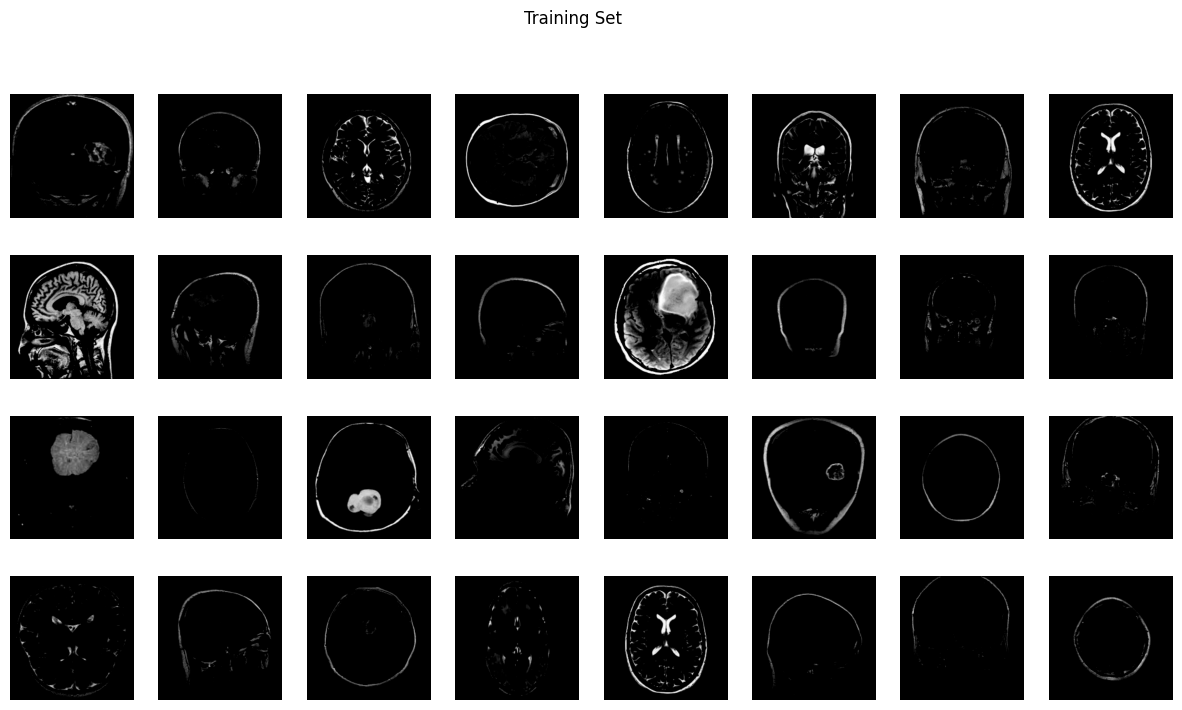

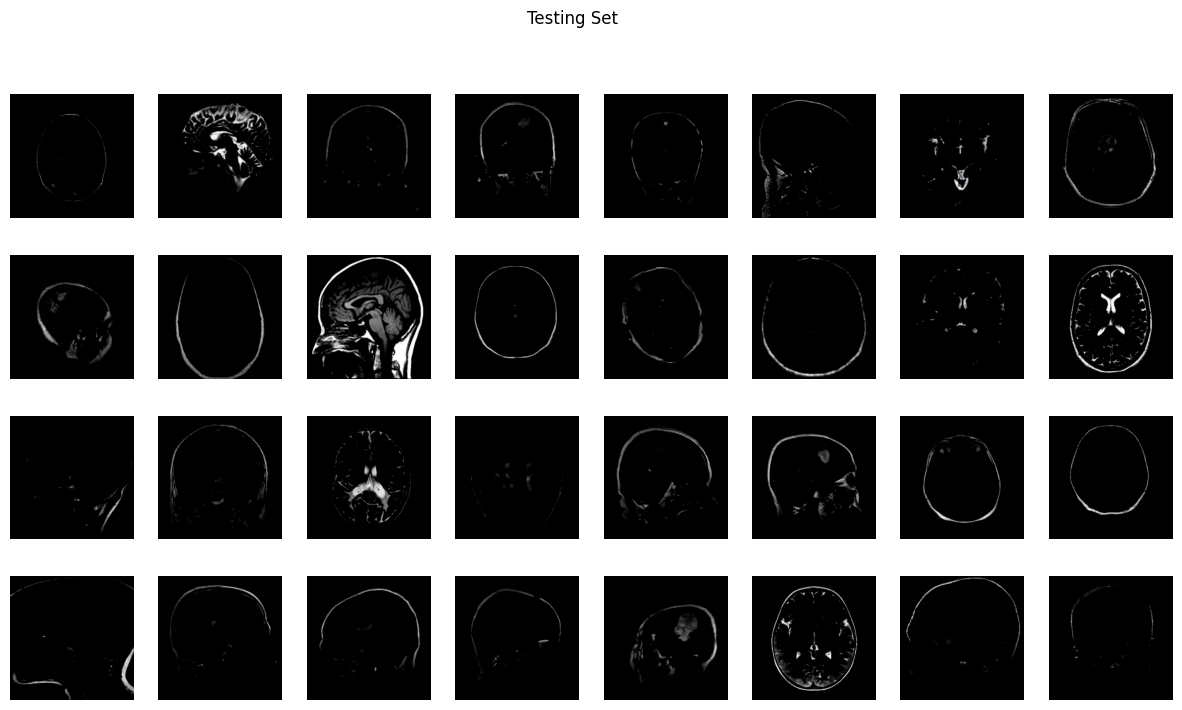

In [7]:
def show_batch(dataloader, title="Batch of MRI Images"):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(4, 8, figsize=(15, 8))
    fig.suptitle(title)
    
    for i, ax in enumerate(axes.flatten()):
        if i < len(images):
            img = images[i].permute(1, 2, 0).numpy()
            ax.imshow(img)
            ax.axis('off')
    plt.show()

show_batch(MRI_train_loader, "Training Set")
show_batch(MRI_test_loader, "Testing Set")

# Loading a pre-trained ResNet-50 model

In [8]:
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 190MB/s] 


# Fine-tuning last layers

In [9]:
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 2)  # Assuming binary classification (Healthy vs Tumor)
)
model = model.to(device)

# Loss and optimizer

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)

# Training loop with Early Stopping

In [11]:
early_stop_patience = 7
best_acc = 0
patience_counter = 0
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(MRI_train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Evaluation
    model.eval()
    correct, total = 0, 0
    all_labels, all_predictions = [], []
    with torch.no_grad():
        for images, labels in MRI_test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    val_acc = 100 * correct / total
    scheduler.step(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(MRI_train_loader):.4f}, Accuracy: {val_acc:.2f}%")
    
    # Early Stopping check
    if val_acc > best_acc:
        best_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_mri_model.pth')  # Save the best model
    else:
        patience_counter += 1
    
    if patience_counter >= early_stop_patience:
        print("Early stopping triggered!")
        break

# Load the best model
model.load_state_dict(torch.load('best_mri_model.pth'))

100%|██████████| 125/125 [00:55<00:00,  2.26it/s]


Epoch [1/30], Loss: 0.2785, Accuracy: 90.80%


100%|██████████| 125/125 [00:31<00:00,  3.95it/s]


Epoch [2/30], Loss: 0.1998, Accuracy: 92.70%


100%|██████████| 125/125 [00:31<00:00,  3.97it/s]


Epoch [3/30], Loss: 0.1766, Accuracy: 95.10%


100%|██████████| 125/125 [00:32<00:00,  3.87it/s]


Epoch [4/30], Loss: 0.1742, Accuracy: 95.60%


100%|██████████| 125/125 [00:31<00:00,  3.95it/s]


Epoch [5/30], Loss: 0.1510, Accuracy: 95.00%


100%|██████████| 125/125 [00:31<00:00,  3.96it/s]


Epoch [6/30], Loss: 0.1395, Accuracy: 95.90%


100%|██████████| 125/125 [00:32<00:00,  3.91it/s]


Epoch [7/30], Loss: 0.1418, Accuracy: 96.20%


100%|██████████| 125/125 [00:31<00:00,  3.96it/s]


Epoch [8/30], Loss: 0.1064, Accuracy: 95.90%


100%|██████████| 125/125 [00:31<00:00,  3.94it/s]


Epoch [9/30], Loss: 0.1131, Accuracy: 96.10%


100%|██████████| 125/125 [00:31<00:00,  3.95it/s]


Epoch [10/30], Loss: 0.1155, Accuracy: 96.50%


100%|██████████| 125/125 [00:31<00:00,  3.95it/s]


Epoch [11/30], Loss: 0.1105, Accuracy: 95.80%


100%|██████████| 125/125 [00:32<00:00,  3.90it/s]


Epoch [12/30], Loss: 0.0968, Accuracy: 96.70%


100%|██████████| 125/125 [00:31<00:00,  3.91it/s]


Epoch [13/30], Loss: 0.0930, Accuracy: 96.50%


100%|██████████| 125/125 [00:31<00:00,  3.98it/s]


Epoch [14/30], Loss: 0.0834, Accuracy: 96.70%


100%|██████████| 125/125 [00:31<00:00,  3.93it/s]


Epoch [15/30], Loss: 0.0988, Accuracy: 97.60%


100%|██████████| 125/125 [00:31<00:00,  3.96it/s]


Epoch [16/30], Loss: 0.0931, Accuracy: 96.40%


100%|██████████| 125/125 [00:31<00:00,  3.92it/s]


Epoch [17/30], Loss: 0.0835, Accuracy: 97.30%


100%|██████████| 125/125 [00:32<00:00,  3.80it/s]


Epoch [18/30], Loss: 0.0859, Accuracy: 97.60%


100%|██████████| 125/125 [00:32<00:00,  3.86it/s]


Epoch [19/30], Loss: 0.0880, Accuracy: 97.50%


100%|██████████| 125/125 [00:32<00:00,  3.84it/s]


Epoch [20/30], Loss: 0.0875, Accuracy: 97.50%


100%|██████████| 125/125 [00:33<00:00,  3.77it/s]


Epoch [21/30], Loss: 0.1026, Accuracy: 97.30%


100%|██████████| 125/125 [00:33<00:00,  3.76it/s]


Epoch [22/30], Loss: 0.0643, Accuracy: 97.60%
Early stopping triggered!


<All keys matched successfully>

# Confusion matrix

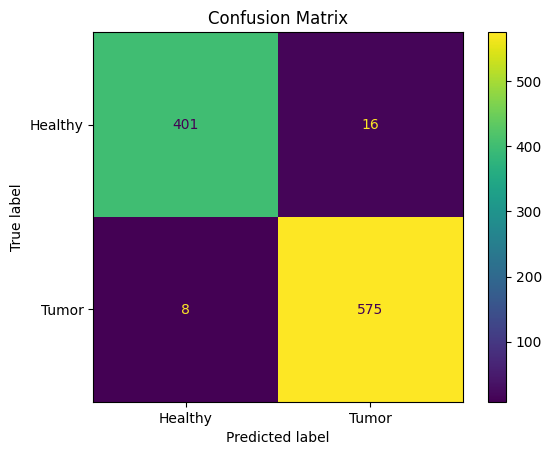

In [12]:
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Tumor"])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Testing on sample images

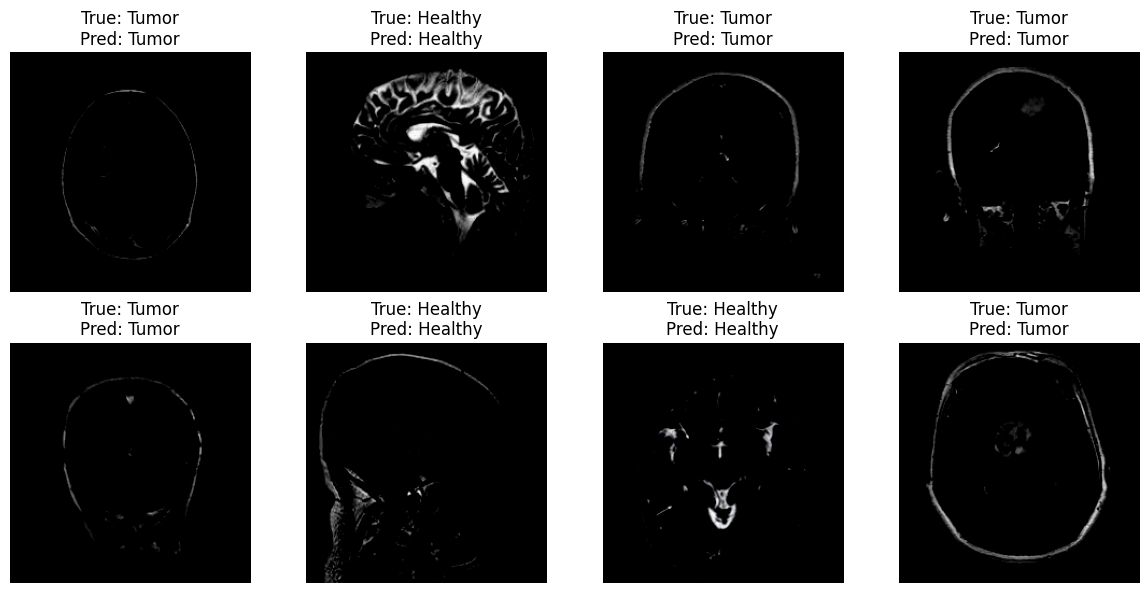

In [13]:
model.eval()
sample_images, sample_labels = next(iter(MRI_test_loader))
sample_images, sample_labels = sample_images.to(device), sample_labels.to(device)
logits = model(sample_images)
_, preds = torch.max(logits, 1)

true_labels = [MRI.classes[label.item()] for label in sample_labels]
pred_labels = [MRI.classes[pred.item()] for pred in preds]

plt.figure(figsize=(12, 6))
for idx in range(8):
    plt.subplot(2, 4, idx + 1)
    img = sample_images[idx].cpu().permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(f"True: {true_labels[idx]}\nPred: {pred_labels[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()